In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 180
pos_dir = '../data/pos'
neg_dir = '../data/neg'

In [3]:
print(os.getcwd())

C:\Users\Alfredo\Documents\GitHub\Capstone3\Notebooks


In [4]:
# Importing Keras 
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer 
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [5]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    "C:/Users/Alfredo/Documents/GitHub/Capstone3/data",  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['pos', 'neg'], #extensions of the folders holding the classes
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (400, 400), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 355 files belonging to 2 classes.


In [6]:
print('\nTraining Dataset:', train)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


We are getting the results of how the data is going to be reviewed:
<ul>
    <li>Data is going to be returned in batches</li>
    <li><b>TensorSpec(shape=(None, 400, 400, 3), dtype=tf.uint8, name=None)</b> represents the features. None represents the batch size, which is None here because it can vary depending on how many samples we have in the last batch; 400, 400 represents the height and width of the images; 3 is the number of channels in the images, indicating they are RGB images. Last, dtype=tf.unit8 tells us that the data type of the image pixels is an unsigned integer of 8 bits.</li>
    <li><b>TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)</b> represents the labels in our dataset. Here, None refers to the batch size; 2 refers to the number of labels in the dataset; whilst dtype=tf.float32 is also a 32-bit floating point. </li>
</ul>

The next step for preprocessing is ensuring that the pixel values of our images are within a 0 to 1 range. First lest confirm the minimum and maximum pixel value for the training dataset:

In [7]:
# Checking minimum and maximum pixel values in the training dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0

Maximum pixel value in the Validation dataset 255


In [8]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

In [9]:
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y)) 

In [10]:
# Checking minimum and maximum pixel values in the training dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


After scaling, it looks like the pixels are withing the 0 and 1 range and we can now continue with building the model. To build the Convolutional Neural Network with Keras, we are going to use the <i>Sequential</i> class. This class allows us to build a linear stack of layers, which is essential for the creation of neural networks.

In [11]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),
        
        
        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),
        
        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

In [12]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy() #remove to try to use the GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [13]:
# Initiating model on GPU
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input. 
                    input_shape = (400,400,3) # Input image shape
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(2, activation = 'sigmoid')) # Binary classification layer

C:\Users\Alfredo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compiling model
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'binary_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [15]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.keras',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [16]:
# Training and Testing Model
try:
    history = model.fit(
        train, epochs = 50)
except Exception as e:
    print("An error occurred:", e)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 827s 35s/step - accuracy: 0.5522 - loss: 12.1280
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 838s 37s/step - accuracy: 0.6908 - loss: 3.8675
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 911s 40s/step - accuracy: 0.7302 - loss: 3.2862
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 940s 41s/step - accuracy: 0.6995 - loss: 2.1204
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1008s 43s/step - accuracy: 0.7469 - loss: 2.6252
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1000s 43s/step - accuracy: 0.7512 - loss: 1.8888
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 996s 43s/step - accuracy: 0.7111 - loss: 2.1251
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1015s 44s/step - accuracy: 0.8102 - loss: 0.8473
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 988s 42s/step - accuracy: 0.7565 - loss: 1.3259
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 945s 41s/step - accuracy: 0.7519 - loss: 1.1202
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1093s 47s/step - accuracy: 0.8378 - loss: 0.6719
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1052s 45

In [17]:
model.save('safety_gear_detect_V3.keras')

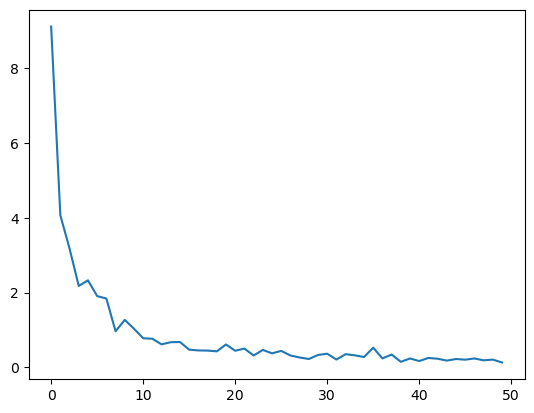

In [18]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])

C:\Users\Alfredo\AppData\Local\Temp\ipykernel_11880\2639163134.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


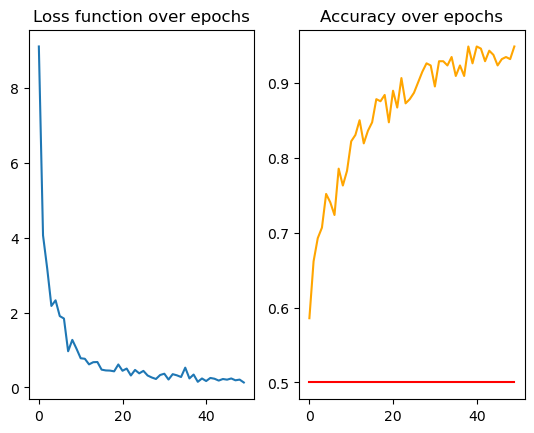

In [19]:
# Creating subplot
fig, (ax1, ax2) = plt.subplots(1,2)

# Loss over epochs
ax1.plot(range(len(history.history['loss'])), history.history['loss'])
ax1.set_title('Loss function over epochs')
ax2.plot(range(len(history.history['loss'])), history.history['accuracy'], color = 'orange')
ax2.plot(range(len(history.history['loss'])), np.ones(50)*0.5, color = 'red')
ax2.set_title('Accuracy over epochs')
fig.show()

In [ ]:
#tf.keras.utils.plot_model(model) # Plotting model 

In [20]:
model.summary() #printing model summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 400, 400, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 400, 400, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 400, 400, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 200, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 200, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 25, 25, 512)    │             

 Total params: 358,688,198 (1.34 GB)

 Trainable params: 179,343,106 (684.14 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 179,343,108 (684.14 MB)

The summary displays the output shapes for each layer and the number of parameters. We can see the output shape for the first layer is (None, 400,400,3) where 400 is both the width and height, while 3 represents the RGB color. In the last dense layer, however, the output shape is (None, 2), where 2 represents the 2 classes for classification.